# Created by Shahriar Rahman Naeem Patwary

# Import Language and moduels

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib
from flask import Flask, request, jsonify

# Sample Traffic Data

In [11]:
data = {
    'date_time' : pd.date_range('2025-10-10 01:00', periods=100, freq='h'),
    'traffic_volume' : np.random.randint(4000,6000,100),
    'temp' : np.random.randint(20,35,100),
    'rain_1h' : np.random.randint(0,3,100),
    'dayofweek' : pd.date_range('2025-10-10 01:00', periods=100, freq='h').weekday,
    'holiday' : np.random.randint(0,2,100)
}

df = pd.DataFrame(data)
df.head()

,date_time,traffic_volume,temp,rain_1h,dayofweek,holiday
0,2025-10-10 01:00:00,5437,20,0,4,0
1,2025-10-10 02:00:00,4520,26,0,4,1
2,2025-10-10 03:00:00,4916,25,2,4,0
3,2025-10-10 04:00:00,5781,20,0,4,0
4,2025-10-10 05:00:00,5434,32,1,4,0


# Sorting, Lag feature and Rolling mean

In [12]:
df = df.sort_values('date_time')

df['lag_1'] = df['traffic_volume'].shift(1)
df['lag_2'] = df['traffic_volume'].shift(2)
df['lag_24'] = df['traffic_volume'].shift(24)

df['rolling_mean'] = df['traffic_volume'].rolling(window=3).mean()
df['rolling_mean'] = df['traffic_volume'].rolling(window=24).mean()

df = df.dropna()
df.head()

,date_time,traffic_volume,temp,rain_1h,dayofweek,holiday,lag_1,lag_2,lag_24,rolling_mean
24,2025-10-11 01:00:00,4736,21,1,5,1,5246.0,5668.0,5437.0,4830.625000
25,2025-10-11 02:00:00,4096,33,1,5,0,4736.0,5246.0,4520.0,4812.958333
26,2025-10-11 03:00:00,4744,33,0,5,1,4096.0,4736.0,4916.0,4805.791667
27,2025-10-11 04:00:00,4556,28,0,5,0,4744.0,4096.0,5781.0,4754.750000
28,2025-10-11 05:00:00,4689,33,0,5,0,4556.0,4744.0,5434.0,4723.708333


# Correlation

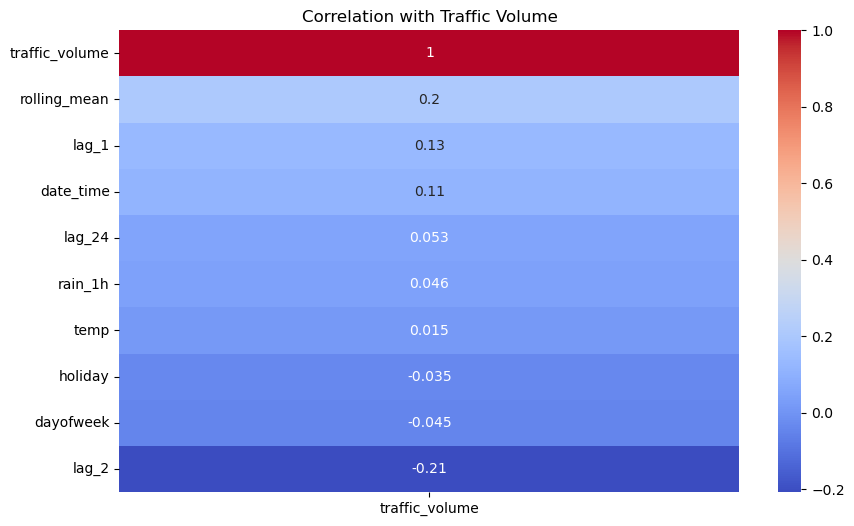

In [18]:
corr = df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr[['traffic_volume']].sort_values(by='traffic_volume', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with Traffic Volume')
plt.show()

# Significance Testing (ANOVA)

In [22]:
anova_holiday = stats.f_oneway(
    df[df['holiday']==0]['traffic_volume'],
    df[df['holiday']==1]['traffic_volume']
)
print("ANOVA - Holiday effect:", anova_holiday)

ANOVA - Holiday effect: F_onewayResult(statistic=np.float64(0.09167896641278593), pvalue=np.float64(0.7629029653473131))


# Model Training & Hyperparameter Tuning

In [26]:
X = df.drop(['traffic_volume','date_time'], axis=1)
y = df['traffic_volume']

param_grid = {
    'n_estimators': [50,100],
    'max_depth': [5,10,None],
    'min_samples_split': [2,5]
}

rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best RMSE:", (-grid.best_score_)**0.5)

Best parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best RMSE: 604.0874280573518


# Adding External Data

In [32]:
acc_data = pd.DataFrame({
    'date_time': df['date_time'],
    'accident_intensity': np.random.randint(0,3,len(df))
})

df = df.merge(acc_data, on='date_time', how='left')
df['accident_intensity'] = df['accident_intensity'].fillna(0)
df.head()

,date_time,traffic_volume,temp,rain_1h,dayofweek,holiday,lag_1,lag_2,lag_24,rolling_mean,accident_intensity
0,2025-10-11 01:00:00,4736,21,1,5,1,5246.0,5668.0,5437.0,4830.625000,0
1,2025-10-11 02:00:00,4096,33,1,5,0,4736.0,5246.0,4520.0,4812.958333,1
2,2025-10-11 03:00:00,4744,33,0,5,1,4096.0,4736.0,4916.0,4805.791667,2
3,2025-10-11 04:00:00,4556,28,0,5,0,4744.0,4096.0,5781.0,4754.750000,1
4,2025-10-11 05:00:00,4689,33,0,5,0,4556.0,4744.0,5434.0,4723.708333,1


# Deployment (Joblib + Flask API)

In [33]:
# Save model
joblib.dump(grid.best_estimator_, 'traffic_model.pkl')

# Minimal Flask API
app = Flask(__name__)
model = joblib.load('traffic_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json['features']  # e.g. [temp, rain_1h, lag_1, lag_2, rolling_mean_3, accident_intensity]
    prediction = model.predict([data])[0]
    return jsonify({'prediction': prediction})

# Uncomment the next line to run the API
# app.run(debug=True)
